**Goal or Agenda**: To build an application called **ADHD Dyslexia EasyScreen** a project that utilizes and showcases the capabilities of Gemma 3n running locally via Ollama.

**Download and Install Ollama locally**

In [ ]:
https://ollama.com/

**Install and run Gemma 3n via Ollama**

In [ ]:
#Install Effective 4B model
ollama run gemma3n:e4b

**Dyslexia screening**

In [ ]:
import whisper
import requests
import json
import os

# -----------------------------
# Step A.1: Use existing .wav file
# -----------------------------
def transcribe_audio(filename):
    print("🧠 Loading Whisper model...")
    model = whisper.load_model("base")  # You can use "tiny", "small", etc. for faster inference
    print(f"🔍 Transcribing '{filename}'...")
    result = model.transcribe(filename)
    print("📝 Transcript:", result["text"])
    return result["text"]

# -----------------------------
# Step A.2: Analyze transcript using Gemma 3n via Ollama
# -----------------------------
def analyze_transcript_with_ollama(transcript):
    prompt = f"""
The child read:
"{transcript}"

Are there signs of dyslexia? Analyze the reading errors.
Give a likelihood score from 0 to 1 and explain briefly.
Respond only in JSON like:
{{
  "dyslexia_score": float,
  "reason": string
}}
"""
    response = requests.post(
        "http://localhost:11434/api/generate",
        json={
            "model": "gemma3n:e4b",
            "prompt": prompt,
            "stream": False
        }
    )

    try:
        data = response.json()
        raw_result = data.get("response", "")
        print("\n📦 Raw model output:\n", raw_result)

        # Remove possible Markdown formatting
        raw_result = raw_result.strip().strip("```json").strip("```")
        parsed = json.loads(raw_result)

        print("\n✅ Dyslexia Analysis:")
        print("Dyslexia Score:", parsed.get("dyslexia_score"))
        print("Reason:", parsed.get("reason"))

    except Exception as e:
        print("❌ Error parsing response:", e)
        print("Full raw response:", response.text)

# -----------------------------
# Main Execution Flow
# -----------------------------
if __name__ == "__main__":
    # 📁 Replace this with the path to your converted .wav file
    audio_file = "Path to the child recording file"

    if not os.path.exists(audio_file):
        print(f"❌ File not found: {audio_file}")
    else:
        transcript = transcribe_audio(audio_file)
        if transcript:
            analyze_transcript_with_ollama(transcript)

The above Python script enables early dyslexia detection by analyzing a child's oral reading using AI. It combines Whisper, an automatic speech recognition (ASR) model, and Gemma 3n, a locally hosted language model via Ollama.

The pipeline follows two main stages:

Audio Transcription:
The script loads OpenAI’s Whisper ASR model (base variant) to transcribe a child’s .wav audio file into text. This captures exactly what the child read aloud.

Dyslexia Analysis:
The transcribed text is sent to a locally running instance of Gemma 3n using the Ollama API. A structured prompt instructs the model to assess potential signs of dyslexia. The response includes:

A dyslexia_score (ranging from 0 to 1)

A concise explanation of observed reading patterns or errors

The script provides real-time, offline results in JSON format, supporting early screening in low-resource or privacy-sensitive environments (e.g., homes, schools, clinics). It is designed to be efficient, explainable, and accessible to non-technical users.

**Sample output**

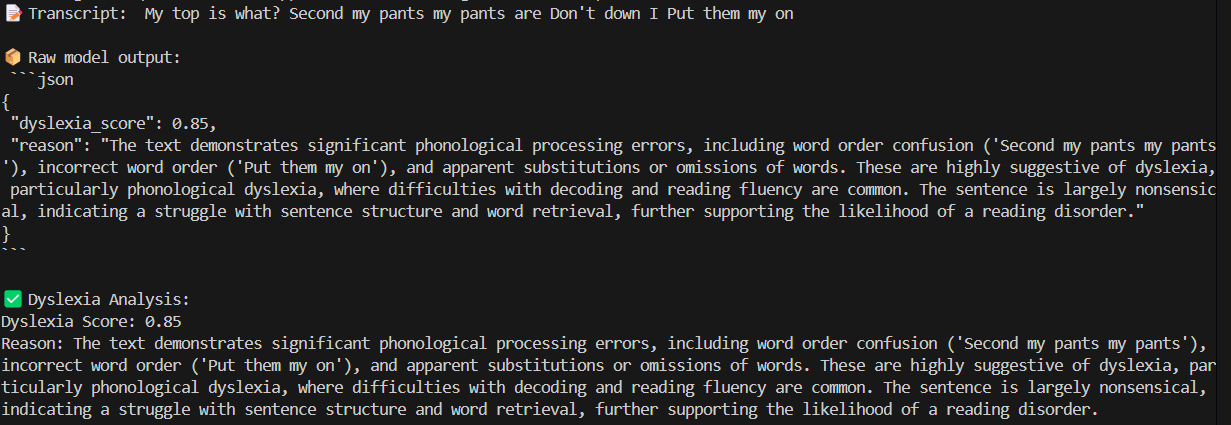

In [ ]:
from IPython.display import Image, display

# Display the image
display(Image(filename='/content/Dyslexia_sample_output.png'))


**ADHD screening**

* **Go-NoGo-Game to test the impulsivity score**




In [ ]:
import pygame
import random
import time
import json

# Init
pygame.init()
WIDTH, HEIGHT = 800, 600
WIN = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Go / No-Go ADHD Test")

FONT = pygame.font.SysFont("Arial", 32)

# Colors
BLUE = (0, 122, 255)
RED = (255, 0, 0)
WHITE = (255, 255, 255)

CIRCLE_RADIUS = 60
CIRCLE_POS = (WIDTH // 2, HEIGHT // 2)

# Settings
TOTAL_TRIALS = 20
STIMULUS_DURATION = 1.2  # seconds to display
INTERVAL = 1.8           # seconds between stimuli

# Results logging
results = {
    "hits": 0,
    "misses": 0,
    "false_alarms": 0,
    "reaction_times_ms": []
}

def draw_text(text, y):
    label = FONT.render(text, True, (0, 0, 0))
    WIN.blit(label, (WIDTH // 2 - label.get_width() // 2, y))

def run_game():
    trial = 0
    clock = pygame.time.Clock()
    running = True

    WIN.fill(WHITE)
    draw_text("Click only on BLUE circles. Press SPACE to start.", 250)
    pygame.display.update()

    # Wait for space
    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                return False
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                break
        else:
            continue
        break

    time.sleep(1)

    while running and trial < TOTAL_TRIALS:
        WIN.fill(WHITE)
        draw_text(f"Trial {trial+1}/{TOTAL_TRIALS}", 20)

        # Choose circle color
        stimulus_type = random.choice(["blue", "red"])
        color = BLUE if stimulus_type == "blue" else RED
        pygame.draw.circle(WIN, color, CIRCLE_POS, CIRCLE_RADIUS)
        pygame.display.update()

        clicked = False
        stimulus_start = time.time()

        # Wait for response
        while time.time() - stimulus_start < STIMULUS_DURATION:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                    break
                elif event.type == pygame.MOUSEBUTTONDOWN:
                    rt = (time.time() - stimulus_start) * 1000  # in ms
                    clicked = True
                    if stimulus_type == "blue":
                        results["hits"] += 1
                        results["reaction_times_ms"].append(rt)
                    else:
                        results["false_alarms"] += 1
                    break
            if not running:
                break
            clock.tick(60)

        # No click on blue = miss
        if stimulus_type == "blue" and not clicked:
            results["misses"] += 1

        pygame.display.flip()
        time.sleep(INTERVAL)
        trial += 1

    pygame.quit()

    # Save results
    with open("go_nogo_results.json", "w") as f:
        json.dump(results, f, indent=2)
    print("📝 Results saved to go_nogo_results.json")
    print(json.dumps(results, indent=2))
    return True

if __name__ == "__main__":
    run_game()

🔍 Go/No-Go Game: This Python script implements a simple Go/No-Go attention test using pygame, designed to screen for ADHD-related cognitive traits such as impulsivity, inattention, and response inhibition.

🎮 Gameplay Mechanics
A total of 20 trials are run.
* In each trial, a circle appears at the center of the screen.
* Blue Circle: The child is expected to click (Go stimulus).
* Red Circle: The child is expected to not click (No-Go stimulus).
* Each stimulus is displayed for 1.2 seconds, followed by a 1.8-second interval.
* Reaction times are recorded for blue circles (correct responses).

📊 Metrics Tracked
* ✅ hits: Correct clicks on blue circles.
* ❌ misses: No response to a blue circle.
* ⚠️ false_alarms: Clicks on red circles.
* ⏱️ reaction_times_ms: Reaction times in milliseconds.

The results are saved as a structured JSON file: go_nogo_results.json.

* **Memory Game to get the attention score**

In [ ]:
import pygame
import random
import time
import json

# Init
pygame.init()
WIDTH, HEIGHT = 800, 600
WIN = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Memory Game - ADHD Test")

FONT = pygame.font.SysFont("Arial", 32)
BIG_FONT = pygame.font.SysFont("Arial", 48)

# Colors
COLORS = {
    "red": (255, 80, 80),
    "green": (80, 255, 80),
    "blue": (80, 80, 255),
    "yellow": (255, 255, 80)
}
COLOR_KEYS = list(COLORS.keys())

# Layout
GRID_POS = [(200, 200), (400, 200), (200, 400), (400, 400)]
SQUARE_SIZE = 150

# Results
results = {
    "rounds": 0,
    "mistakes": 0,
    "click_times_ms": [],
    "max_sequence_recalled": 0
}

def draw_grid():
    for i, color in enumerate(COLOR_KEYS):
        x, y = GRID_POS[i]
        pygame.draw.rect(WIN, COLORS[color], (x, y, SQUARE_SIZE, SQUARE_SIZE))
    pygame.display.update()

def flash_sequence(seq):
    for color in seq:
        i = COLOR_KEYS.index(color)
        x, y = GRID_POS[i]
        pygame.draw.rect(WIN, COLORS[color], (x, y, SQUARE_SIZE, SQUARE_SIZE))
        pygame.display.update()
        time.sleep(0.5)
        pygame.draw.rect(WIN, (30, 30, 30), (x, y, SQUARE_SIZE, SQUARE_SIZE))
        pygame.display.update()
        time.sleep(0.2)
    draw_grid()

def get_color_clicked(pos):
    for i, (x, y) in enumerate(GRID_POS):
        if x <= pos[0] <= x + SQUARE_SIZE and y <= pos[1] <= y + SQUARE_SIZE:
            return COLOR_KEYS[i]
    return None

def show_text(msg, y_offset=0):
    WIN.fill((255, 255, 255))
    text = BIG_FONT.render(msg, True, (0, 0, 0))
    WIN.blit(text, (WIDTH // 2 - text.get_width() // 2, HEIGHT // 2 + y_offset))
    pygame.display.update()

def run_memory_game():
    sequence = []
    level = 1
    running = True

    show_text("Click to Start")
    waiting = True
    while waiting:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                return False
            if event.type == pygame.MOUSEBUTTONDOWN:
                waiting = False

    while running:
        sequence.append(random.choice(COLOR_KEYS))
        results["rounds"] += 1
        show_text(f"Round {level}")
        time.sleep(1)

        WIN.fill((30, 30, 30))
        draw_grid()
        flash_sequence(sequence)

        user_sequence = []
        index = 0
        start_time = time.time()
        while index < len(sequence):
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                    break
                if event.type == pygame.MOUSEBUTTONDOWN:
                    clicked_color = get_color_clicked(pygame.mouse.get_pos())
                    if not clicked_color:
                        continue

                    rt = int((time.time() - start_time) * 1000)
                    results["click_times_ms"].append(rt)

                    if clicked_color == sequence[index]:
                        user_sequence.append(clicked_color)
                        index += 1
                        start_time = time.time()
                    else:
                        results["mistakes"] += 1
                        show_text("❌ Wrong! Game Over")
                        running = False
                        break
            else:
                continue
            break

        if running:
            results["max_sequence_recalled"] = len(sequence)
            level += 1
            start_time = time.time()

    pygame.quit()
    with open("memory_game_results.json", "w") as f:
        json.dump(results, f, indent=2)
    print("📝 Results saved to memory_game_results.json")
    print(json.dumps(results, indent=2))
    return True

if __name__ == "__main__":
    run_memory_game()

Memory Game: This Python script implements a visual memory sequence test using pygame. It evaluates a user's working memory, attention span, and recall ability, key cognitive domains often impacted by ADHD.

🎮 Gameplay Mechanics
* The player is shown a sequence of colored squares (red, green, blue, yellow), which light up in a random order.

* The user must click the squares in the exact order of the flashing sequence.

* The sequence grows by one color each round, testing memory retention and sustained focus.

* The game ends upon the first mistake.

📊 Metrics Tracked
* 🔁 rounds: Number of levels/rounds completed.

* ❌ mistakes: Incorrect clicks (the game ends on the first mistake).

* ⏱️ click_times_ms: Reaction time in milliseconds per click.

* 🧠 max_sequence_recalled: Length of the longest sequence the player successfully remembered.

The output is saved as a structured JSON file: memory_game_results.json.

* **Task switching game for the flexibility score**

In [ ]:
import pygame
import random
import time
import json

# Game setup
pygame.init()
WIDTH, HEIGHT = 600, 400
WIN = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("ADHD Task Switching Test")

FONT = pygame.font.SysFont(None, 36)
BIG_FONT = pygame.font.SysFont(None, 48)

COLORS = {"red": (255, 0, 0), "blue": (0, 0, 255), "green": (0, 255, 0)}
TASKS = ["Tap only RED", "Now tap only GREEN", "Now tap only BLUE"]
TASK_KEYS = ["red", "green", "blue"]

# Track performance
results = {
    "reaction_times_ms": [],
    "errors": 0,
    "task_switch_accuracy": []
}

def draw_start_screen():
    WIN.fill((255, 255, 255))
    title = BIG_FONT.render("ADHD Task Switching Test", True, (0, 0, 0))
    start_msg = FONT.render("Click anywhere to start", True, (0, 0, 0))
    WIN.blit(title, (WIDTH // 2 - title.get_width() // 2, HEIGHT // 3))
    WIN.blit(start_msg, (WIDTH // 2 - start_msg.get_width() // 2, HEIGHT // 2))
    pygame.display.update()

def wait_for_click():
    waiting = True
    while waiting:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()
            elif event.type == pygame.MOUSEBUTTONDOWN:
                waiting = False

def get_random_boxes():
    positions = [(100, 150), (250, 150), (400, 150)]
    random.shuffle(positions)
    keys = list(COLORS.keys())
    return {keys[i]: pygame.Rect(positions[i][0], positions[i][1], 100, 100) for i in range(3)}

def draw_screen(active_task, boxes):
    WIN.fill((255, 255, 255))

    # Draw instruction
    instruction = FONT.render(TASKS[active_task], True, (0, 0, 0))
    WIN.blit(instruction, (WIDTH // 2 - instruction.get_width() // 2, 50))

    # Draw boxes
    for color, rect in boxes.items():
        pygame.draw.rect(WIN, COLORS[color], rect)

    pygame.display.update()

def get_clicked_color(pos, boxes):
    for color, rect in boxes.items():
        if rect.collidepoint(pos):
            return color
    return None

def run_task_switch_game(rounds=6):
    draw_start_screen()
    wait_for_click()

    running = True
    task_index = 0

    while running and task_index < rounds:
        boxes = get_random_boxes()
        draw_screen(task_index % len(TASKS), boxes)
        pygame.event.clear()

        start = time.time()
        clicked = False

        while not clicked:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                    break
                if event.type == pygame.MOUSEBUTTONDOWN:
                    clicked_color = get_clicked_color(pygame.mouse.get_pos(), boxes)
                    if clicked_color:
                        reaction_time = int((time.time() - start) * 1000)
                        correct_color = TASK_KEYS[task_index % len(TASK_KEYS)]

                        if clicked_color == correct_color:
                            results["reaction_times_ms"].append(reaction_time)
                            results["task_switch_accuracy"].append(1)
                        else:
                            results["errors"] += 1
                            results["task_switch_accuracy"].append(0)

                        task_index += 1
                        clicked = True

        # Optional delay between tasks
        time.sleep(0.5)

    pygame.quit()

    with open("task_switch_results.json", "w") as f:
        json.dump(results, f, indent=2)

    print("✅ Task Switching Test Complete")
    print(json.dumps(results, indent=2))

if __name__ == "__main__":
    run_task_switch_game()

Task Switching Game: This Python script implements a task-switching assessment using pygame. It evaluates a user’s cognitive flexibility — the ability to rapidly switch mental focus based on changing instructions — which is often impaired in individuals with ADHD.

🎮 Gameplay Mechanics
* The player is given changing instructions (e.g., "Tap only RED", then "Tap only GREEN", etc.).

* On screen, three colored boxes (red, green, blue) are randomly placed.

* The player must click only the color instructed on each round.

* The game measures how accurately and quickly the player can switch tasks.

📊 Metrics Tracked
* ⏱️ reaction_times_ms: Time taken to respond (in milliseconds) for each task.

* ❌ errors: Number of incorrect color taps.

* ✅ task_switch_accuracy: List tracking whether the user correctly followed the instruction in each round (1 for correct, 0 for incorrect).

The results are exported as a structured JSON file: task_switch_results.json.

* **ADHD analysis based on the all the above games score**

In [ ]:
import json
import requests
import os

# -----------------------------
# Load results from each game
# -----------------------------
def load_json_results(filepath):
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            return json.load(f)
    return {}

# -----------------------------
# Map ADHD score to likelihood level
# -----------------------------
def get_likelihood_level(score):
    if score is None:
        return "Unknown"
    if score < 0.3:
        return "Low"
    elif score >= 0.3 and score < 0.7:
        return "Moderate"
    else:
        return "High"

# -----------------------------
# Format & send to Gemma 3n
# -----------------------------
def analyze_adhd_with_ollama(go_nogo, memory, task_switch):
    prompt = f"""
The following are the results of a child's performance in three cognitive games used to assess ADHD traits:

### Go/No-Go Task (Impulsivity)
- Hits: {go_nogo.get('hits')}
- Misses: {go_nogo.get('misses')}
- False Alarms: {go_nogo.get('false_alarms')}
- Reaction Times (ms): {go_nogo.get('reaction_times_ms')}

### Memory Game (Attention Span)
- Rounds Played: {memory.get('rounds')}
- Mistakes: {memory.get('mistakes')}
- Max Sequence Recalled: {memory.get('max_sequence_recalled')}
- Click Times (ms): {memory.get('click_times_ms')}

### Task Switching Game (Cognitive Flexibility)
- Reaction Times (ms): {task_switch.get('reaction_times_ms')}
- Errors: {task_switch.get('errors')}
- Task Switch Accuracy: {task_switch.get('task_switch_accuracy')}

---

Use this strict scoring rubric to assess ADHD likelihood (score between 0.0 and 1.0). Only apply points if thresholds are exceeded. Base this on behavioral markers, not diagnoses.

---

**Impulsivity (Go/No-Go):**
- Measures tendency to act without thinking.
- Add +0.3 ONLY IF (misses > 3 OR false alarms > 3)
- Add +0.2 ONLY IF average reaction time > 1000ms (suggests delayed inhibition)

**Inattention (Memory Game):**
- Measures sustained attention and working memory.
- Add +0.2 ONLY IF max sequence recalled < 3
- Add +0.2 ONLY IF total mistakes > 3

**Cognitive Flexibility (Task Switching):**
- Measures ability to adapt to changing rules.
- Add +0.2 ONLY IF task switch accuracy < 0.6
- Add +0.1 ONLY IF average reaction time > 1500ms

---

**Total ADHD Score = sum of above (clip between 0 and 1)**

Then classify:
- Score < 0.3 → "Low likelihood of ADHD traits"
- 0.3 ≤ Score < 0.7 → "Moderate likelihood"
- Score ≥ 0.7 → "High likelihood"

Use empathetic, child-friendly explanations when presenting results.

### OUTPUT FORMAT (JSON only):
{{
  "impulsivity_score": float,
  "attention_score": float,
  "flexibility_score": float,
  "adhd_score": float,
  "likelihood_level": string,
  "reason": string
}}

Explain the reasoning clearly, justifying each score **only if** threshold was exceeded.
"""

    response = requests.post(
        "http://localhost:11434/api/generate",
        json={
            "model": "gemma3n:e4b",
            "prompt": prompt,
            "stream": False
        }
    )

    try:
        data = response.json()
        raw = data.get("response", "")
        print("\n📦 Raw model output:\n", raw)

        # Clean markdown formatting if present
        raw = raw.strip().removeprefix("```json").removesuffix("```").strip()
        parsed = json.loads(raw)

        adhd_score = parsed.get("adhd_score")
        likelihood_level = parsed.get("likelihood_level") or get_likelihood_level(adhd_score)

        result = {
            "impulsivity_score": parsed.get("impulsivity_score"),
            "attention_score": parsed.get("attention_score"),
            "flexibility_score": parsed.get("flexibility_score"),
            "adhd_score": adhd_score,
            "likelihood_level": likelihood_level,
            "reason": parsed.get("reason")
        }

        print("\n✅ ADHD Analysis:")
        print(json.dumps(result, indent=2))

    except Exception as e:
        print("❌ Error parsing response:", e)
        print("Full raw response:", response.text)

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    go_nogo = load_json_results("go_nogo_results.json")
    memory = load_json_results("memory_game_results.json")
    task_switch = load_json_results("task_switch_results.json")

    analyze_adhd_with_ollama(go_nogo, memory, task_switch)

This Python script evaluates a child's likelihood of exhibiting ADHD traits based on their performance in three cognitive mini-games:

🕹️ Games Analyzed
* Go/No-Go Task (measures impulsivity)

* Memory Game (measures attention span)

* Task Switching Game (measures cognitive flexibility)

⚙️ How It Works
* Loads JSON files containing game results:
  * go_nogo_results.json

  * memory_game_results.json

  * task_switch_results.json

Builds a detailed prompt containing:

* Game performance metrics

* A strict rubric with scoring thresholds for ADHD-relevant traits

Sends the prompt to a local Ollama instance running the gemma3n:e4b model (http://localhost:11434/api/generate).

Parses the model's JSON response, extracting:

* Scores for impulsivity, attention, and flexibility

* Final ADHD score (between 0.0 and 1.0)

* Likelihood level (Low, Moderate, or High)

* Empathetic reasoning for the result

Prints the full analysis to the console.

**Sample output**

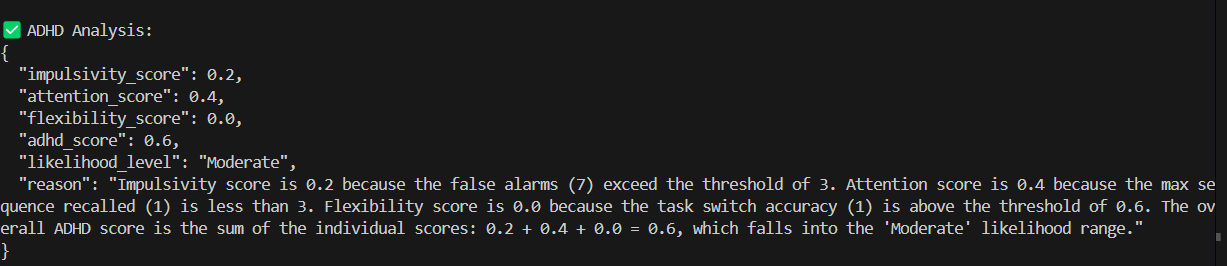

In [ ]:
from IPython.display import Image, display

# Display the image
display(Image(filename='/content/ADHD_sample_output.png'))

**Conclusion**

This project delivers an evidence-based, child-friendly assessment of Dyslexia and ADHD-related traits by leveraging real-time behavioral data from reading recordings and interactive cognitive games.

By integrating a structured, rule-based scoring rubric with local LLM inference via Gemma 3n, the system provides transparent, consistent, and empathetic interpretations of cognitive performance. While not a diagnostic tool, it serves as a powerful early screening aid—equipping educators, caregivers, and clinicians with actionable insights to better understand and support children's learning and neurodevelopment.